# Data Mining Project

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

account = read_csv('../data/account.csv',delimiter=';')
card_dev = read_csv('../data/card_dev.csv',delimiter=';')
client = read_csv('../data/client.csv',delimiter=';')
disp = read_csv('../data/disp.csv',delimiter=';')
district = read_csv('../data/district.csv',delimiter=';')
loan_dev = read_csv('../data/loan_dev.csv',delimiter=';')
trans_dev = read_csv('../data/trans_dev.csv',delimiter=';')

/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_14563/1307852591.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = read_csv('../data/trans_dev.csv',delimiter=';')


In [77]:
from datetime import datetime

account_loan = account.merge(loan_dev, on='account_id', suffixes=('_account','_loan'))
disp_account_loan = disp.merge(account_loan, on='account_id', suffixes=('_disp','_account_loan'))
client_disp_account_loan = client.merge(disp_account_loan, on='client_id',suffixes=('_client','_disp_account_loan'))

def parse_date(d):
    year = int(str(d)[0:2])
    month = int(str(d)[2:4])
    day = int(str(d)[4:6])
    return {'year':year, 'month':month, 'day':day}

def calculate_age(client):
  birth_date = parse_date(client['birth_number'])
  date_at_loan = parse_date(client['date_loan'])
  
  female = birth_date['month'] >= 50
  
  if female:
    client['sex'] = 'female' # or 1 ?
    birth_date['month'] -= 50
  else:
    client['sex'] = 'male' # or 0 ?
  
  client['age_at_loan'] = date_at_loan['year'] - birth_date['year'] - ((date_at_loan['month'], date_at_loan['day']) < (birth_date['month'], birth_date['day']))
    
  return client

client_disp_account_loan = client_disp_account_loan.apply(lambda c: calculate_age(c), axis=1)
client_disp_account_loan

,client_id,birth_number,district_id_client,disp_id,account_id,type,district_id_disp_account_loan,frequency,date_account,loan_id,date_loan,amount,duration,payments,status,sex,age_at_loan
0,2,450204,1,2,2,OWNER,1,monthly issuance,930226,4959,940105,80952,24,3373,1,male,48
1,3,406009,1,3,2,DISPONENT,1,monthly issuance,930226,4959,940105,80952,24,3373,1,female,53
2,25,395423,21,25,19,OWNER,21,monthly issuance,950407,4961,960429,30276,12,2523,-1,female,57
3,78,445613,16,78,67,OWNER,16,monthly issuance,941019,4973,960502,165960,24,6915,1,female,51
4,158,455703,40,158,132,OWNER,40,issuance after transaction,960511,4996,961106,88440,12,7370,1,female,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,13845,730216,15,13537,11265,OWNER,15,monthly issuance,930114,7284,930915,52788,12,4399,1,male,20
399,13955,456030,1,13647,11349,OWNER,1,weekly issuance,950526,7304,951029,419880,60,6998,1,female,49
400,13956,430406,1,13648,11349,DISPONENT,1,weekly issuance,950526,7304,951029,419880,60,6998,1,male,52
401,13968,680413,61,13660,11359,OWNER,61,monthly issuance,941001,7305,960806,54024,12,4502,1,male,28


## Business Understanding

The bank wants to improve their services. For instance, the bank managers have only vague idea, who is a good client (whom to offer some additional services) and who is a bad client (whom to watch carefully to minimize the bank loses). Fortunately, the bank stores data about their clients, the accounts (transactions within several months), the loans already granted, the credit cards issued. The bank managers hope to improve their understanding of customers and seek specific actions to improve services. A mere application of a discovery tool will not be convincing for them.  

To test a data mining approach to help the bank managers, it was decided to address two problems, a descriptive and a predictive one. While the descriptive problem was left open, the predictive problem is the prediction of whether a loan will end successfuly.

## Data Understanding

<AxesSubplot:>

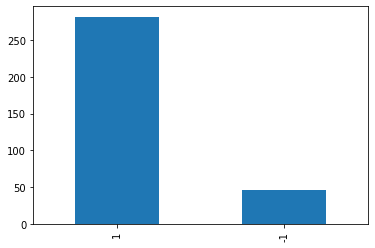

In [23]:
loan_dev['status'].value_counts().plot.bar()


- idade vs status
- número de disponentes vs status 
    - quantas pessoas podem depositar naquela conta / contas quantas aquela pessoa tem ??
- amount da loan vs status 
    - isto tipo não sei se faz super sentido era mais para perceber se o risco aumenta quanto maior for a loan ou se não podems concluir isso
- crime rate vs status
- taxa de desemprego vs status
- salário médio da região
- ... outros dados demográficos vs status ??
- diferença salário médio e dinheiro da loan pago a cada mês vs status
    - se o que a pessoa paga em cada mês é quase a totalidade do seu salário, é mais provável que não possa pagar a dada altura
- duration vs status
- género vs status
- frequência com que é utilizada a conta vs status
    - ver pelo número de transactions, no fundo é se é cliente ativo ou não
- percentagem de depósitos/débitos vs status 
    - my thought process foi que se eu só uso a conta para debitar dinheiro secalhar tou a gastar mais do que o ganho kk
- quantas loans tem 'ativas' 
    - ver interseção data de aceitação + duração
- ...


<AxesSubplot:title={'center':'duration'}, xlabel='status'>

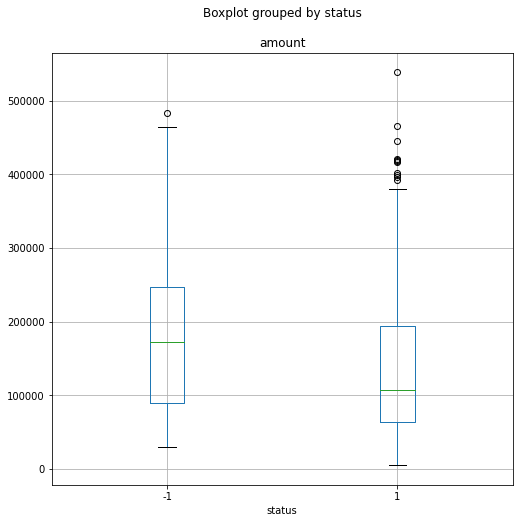

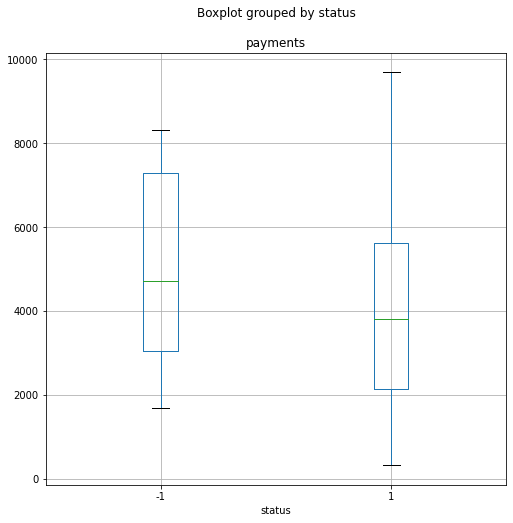

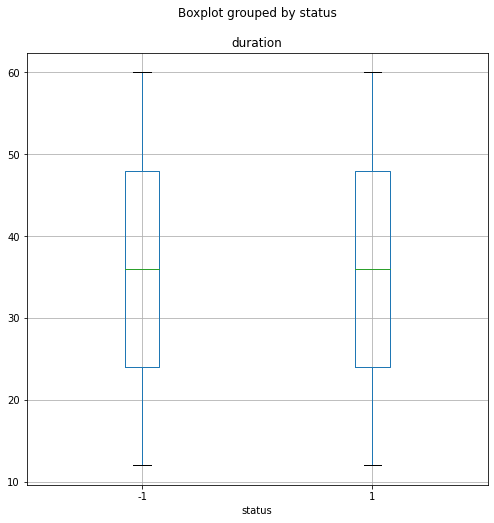

In [24]:
loan_dev.boxplot(column='amount', by='status', figsize=(8,8))
loan_dev.boxplot(column='payments', by='status', figsize=(8,8))
loan_dev.boxplot(column='duration', by='status', figsize=(8,8))


Since the boxes are not totally aligned, there might be a relation between the loan amount and the successfulness of a loan. The higher the amount, the most likely it is to fail. The differences in the graphics aren't, however, significant and our conclusions are enforced by logic.

# Idade vs acount

<AxesSubplot:title={'center':'age_at_loan'}, xlabel='status'>

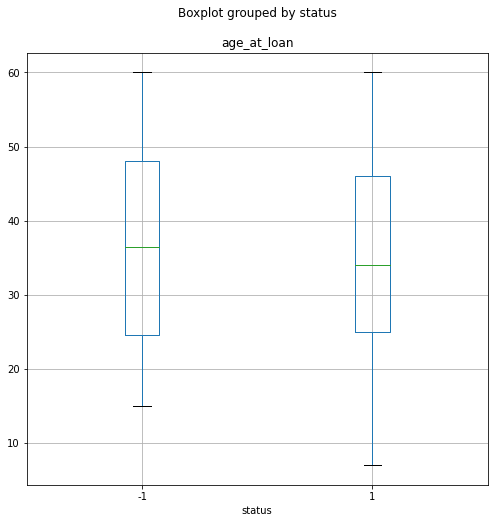

In [69]:
client.boxplot(column='age_at_loan', by='status', figsize=(8,8))


## Data Preparation

## Model